In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
import onnx
from onnx2pytorch import ConvertModel

In [2]:
import sys
print(sys.executable)

/home/ufuk/miniconda3/envs/autolirpa_icnn/bin/python


In [3]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

from vnnlib.compat import read_vnnlib_simple

import torch
import numpy as np
from collections import OrderedDict

In [4]:
def load_onnx_model(onnx_path, input_shape):
    onnx_model = onnx.load(onnx_path)
    torch_model = ConvertModel(onnx_model).double()
    
    x_concrete = torch.zeros(input_shape)
    model = BoundedModule(torch_model, x_concrete)
    return model

In [5]:
def load_vnnlib_spec(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]
    
    bnds = np.array(bnds)
    lbs = bnds[:,0]
    ubs = bnds[:,1]
    
    data_min = torch.tensor(lbs, dtype=torch.float32).reshape(input_shape)
    data_max = torch.tensor(ubs, dtype=torch.float32).reshape(input_shape)
    center = 0.5*(data_min + data_max)

    ptb = PerturbationLpNorm(x_L=data_min, x_U=data_max)
    x = BoundedTensor(center, ptb)
    
    return x

In [6]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [7]:
transform = Compose([ToTensor(),  Normalize(0.5, 0.5)])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

In [8]:
nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device(device)), strict=False)


<All keys matched successfully>

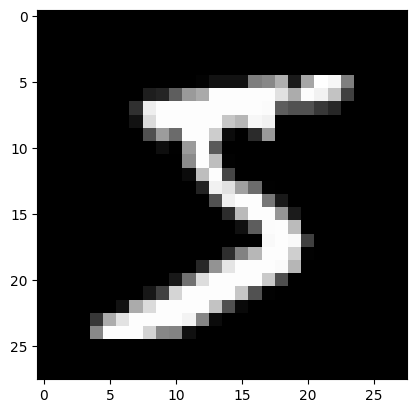

The label is 5
NN classifies image correctly as 5


In [9]:
# image to do the verification for
image_index = 0

# epsilon radius
eps = 0.026

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = False

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")

if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")

In [10]:
onnx_model_path = 'nn.onnx'

torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)

# Use the actual image tensor as input
torch.onnx.export(nn, torch_image, onnx_model_path)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


In [11]:
# Open the VNNLIB file
with open('mnist_image_0.vnnlib', 'w') as f:
    # Write a comment describing the problem
    f.write('// Perturbation of 0.026 on the first image of the MNIST dataset\n')

    # Write the input constraints
    for i, pixel in enumerate(image.view(-1)):
        pixel = pixel.item()
        f.write(f'(<= (- x{i} {pixel}) 0.026)\n')
        f.write(f'(<= (- {pixel} x{i}) 0.026)\n')

In [12]:
onnx_path = 'nn.onnx' #'example_specs/mnist-net_256x4.onnx'
vnnlib_path = 'example_specs/prop_0_spiral_25.vnnlib' # 

In [13]:
def load_onnx_model(onnx_path, input_shape):
    onnx_model = onnx.load(onnx_path)
    torch_model = ConvertModel(onnx_model).float()
    
    x_concrete = torch.zeros(input_shape, dtype=data_type)
    model = BoundedModule(torch_model, x_concrete)
    return model

model = load_onnx_model(onnx_path, [1,1,1,784])
x = load_vnnlib_spec(vnnlib_path, [1,1,1,784], 10)

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))
/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/model.py:163: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not self.experimental and inputs[0

In [14]:
model.compute_bounds(x=(x,), method='ibp')

(tensor([[ -5.1016,  -5.4279,  -5.4882,  -1.8619, -10.0629,  -2.3619,  -6.8763,
           -4.8774,  -8.1820,  -7.3758]], grad_fn=<AddBackward0>),
 tensor([[ 6.0288,  5.8087,  7.7046,  9.9662,  0.9998, 10.0238,  3.6404,  6.8366,
           4.9296,  4.6805]], grad_fn=<AddBackward0>))

In [15]:
model.compute_bounds(x=(x,), method='crown')

[[tensor([[[[-0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150, -0.0150,
           -0.0150, -0.0150, -0.0150

In [20]:
bounds = []
for layer_name in model.input_name:
    layer = model[layer_name]
    lower = layer.lower
    upper = layer.upper
    bounds.append([lower, upper])
    
print(bounds)

tensor([[[[0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
           0.0300, 0.0300